In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#109747'
NONTARGET_COLOR = 'black'


CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023

stdfont = 14
stdyfrac = 0.06

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))#,'AE_267']))

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\Manuscript\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

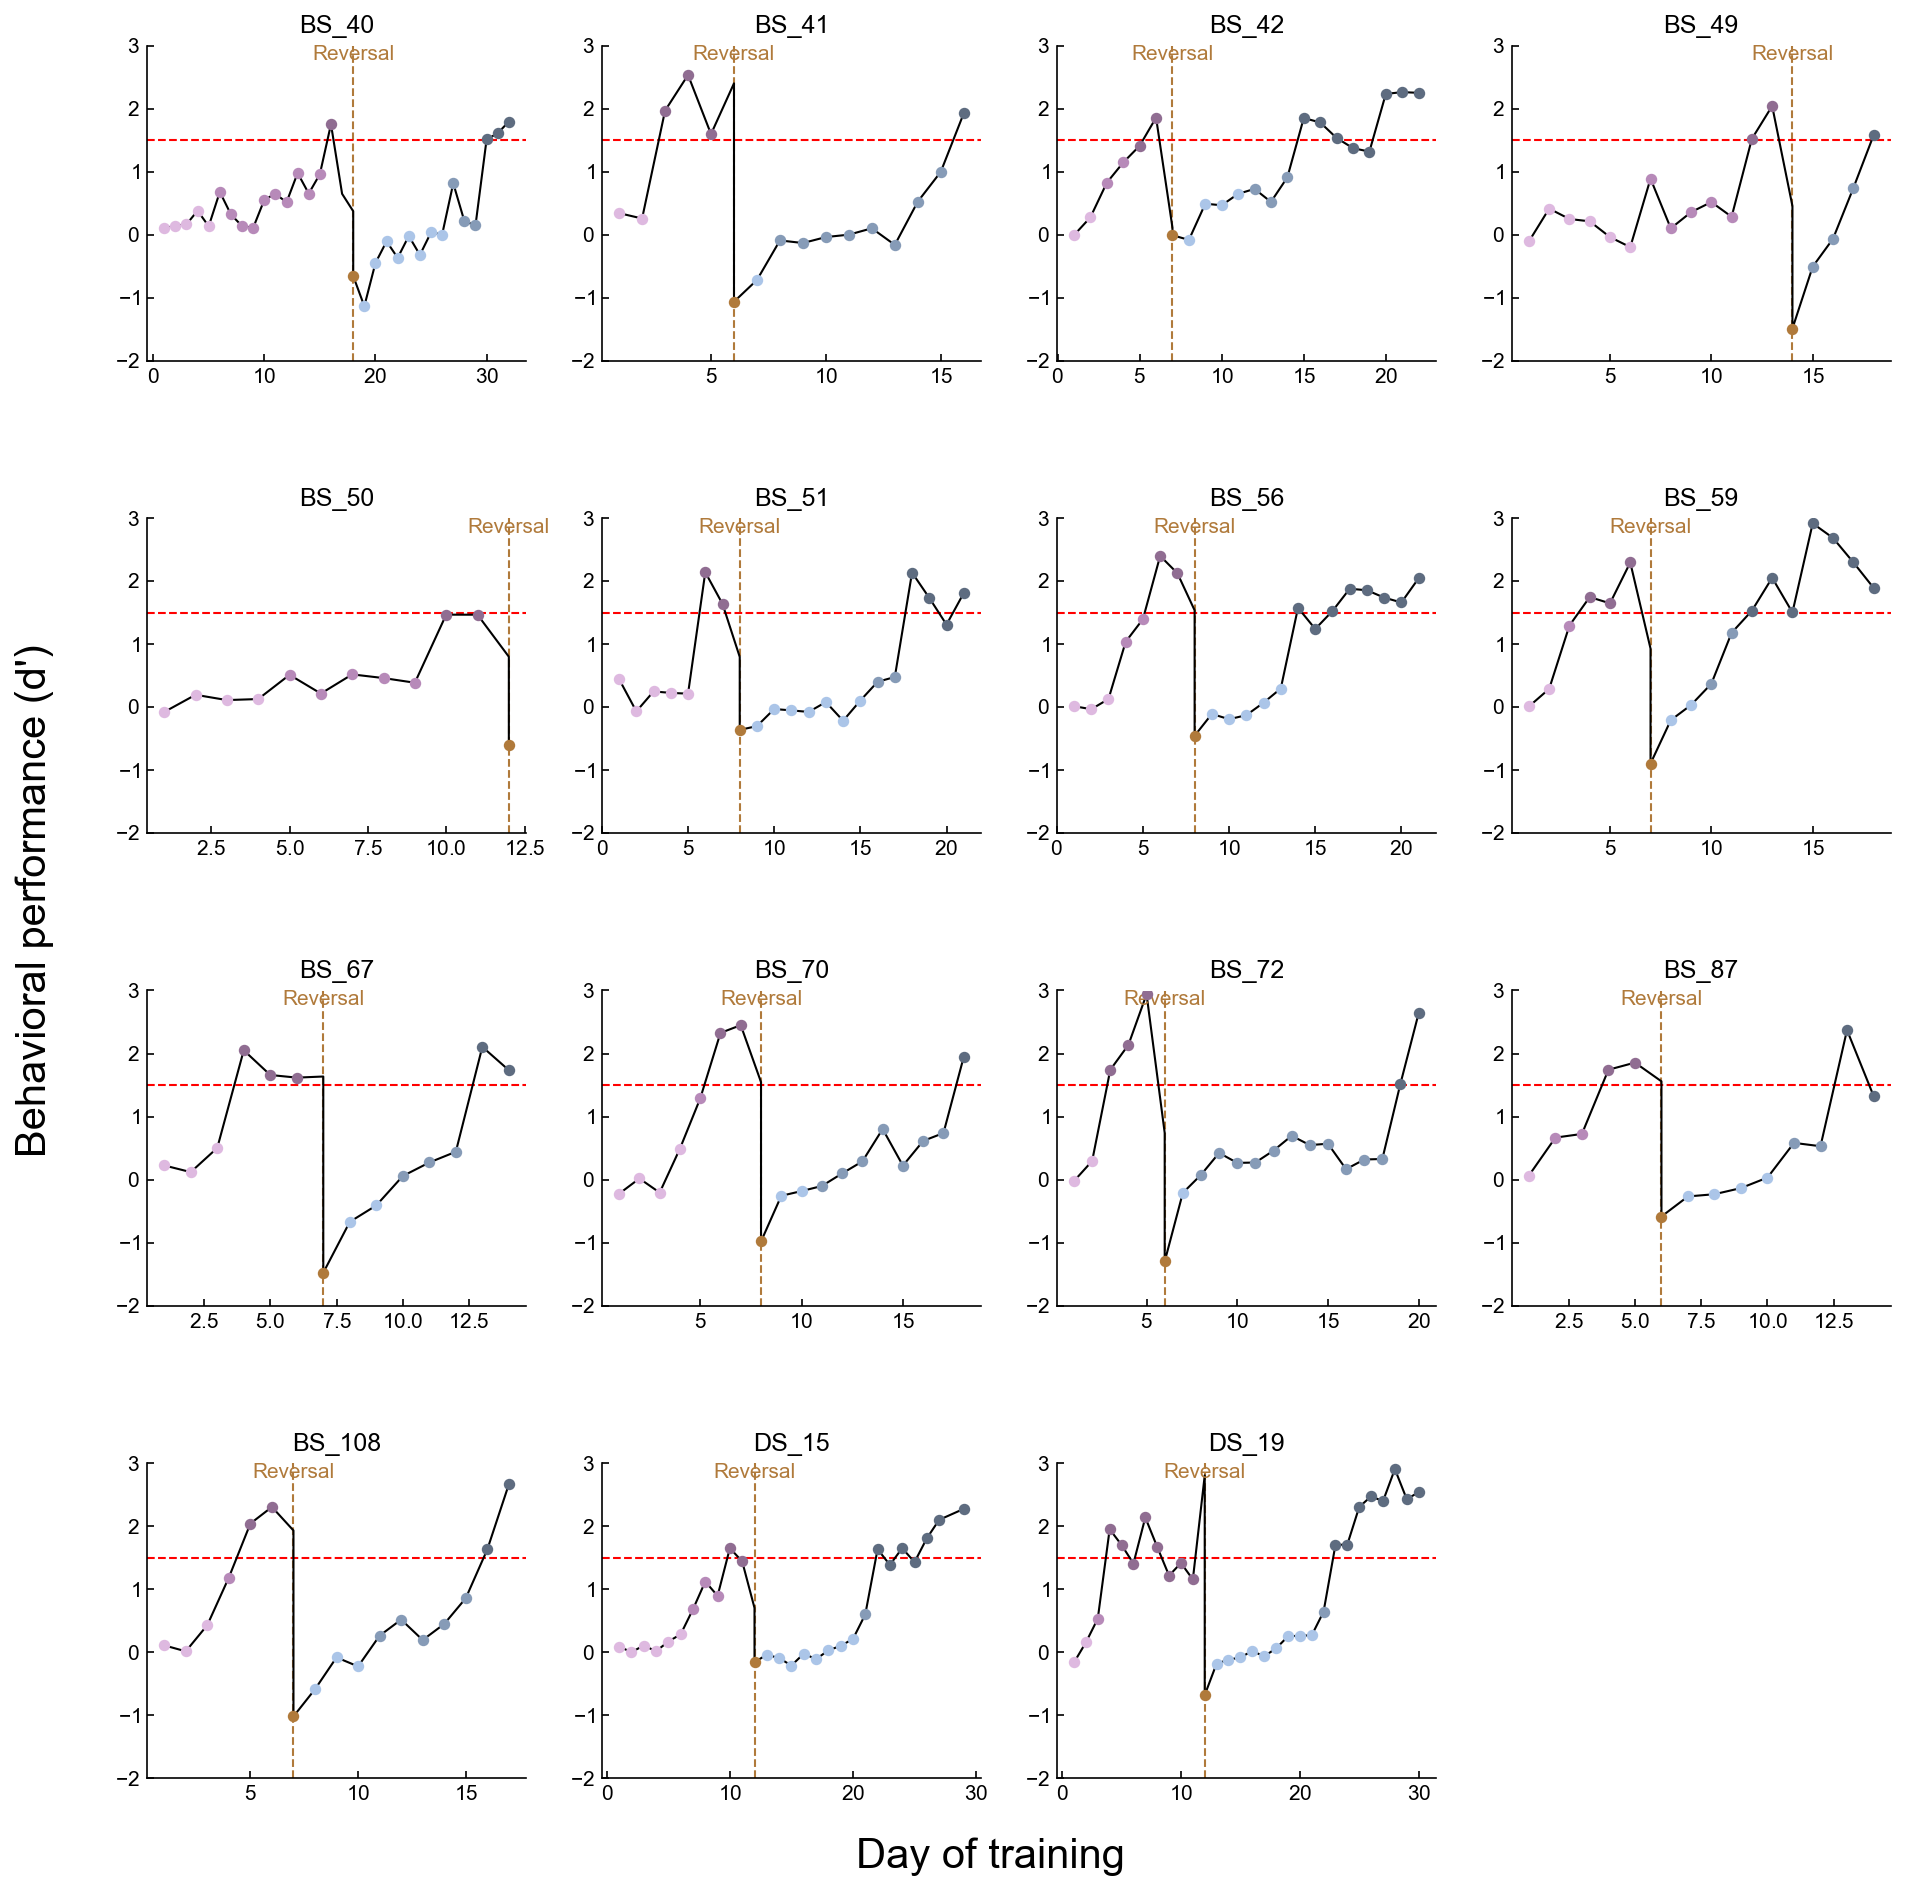

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

In [5]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 554/554 [00:07<00:00, 78.74it/s] 


In [6]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1831/1831 [00:34<00:00, 52.66it/s] 

errors for: []


# NCR

In [7]:
Tuning_target_preearly = []
Tuning_target_prelate = []
Tuning_target_preexpert = []
Tuning_target_postearly = []
Tuning_target_postlate = []
Tuning_target_postexpert = []
Tuning_target_switch = []

Tuning_nontarget_preearly = []
Tuning_nontarget_prelate = []
Tuning_nontarget_preexpert = []
Tuning_nontarget_postearly = []
Tuning_nontarget_postlate = []
Tuning_nontarget_postexpert = []
Tuning_nontarget_switch = []

Tuning_index_preearly = []
Tuning_index_prelate = []
Tuning_index_preexpert = []
Tuning_index_postearly = []
Tuning_index_postlate = []
Tuning_index_postexpert = []
Tuning_index_switch = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        FR_target = sessionfile.responsiveness[clust]['target'].FR
        FR_bl_target = sessionfile.responsiveness[clust]['target'].FRbaseline
        FR_nontarget = sessionfile.responsiveness[clust]['nontarget'].FR
        FR_bl_nontarget = sessionfile.responsiveness[clust]['nontarget'].FRbaseline
        Tuning_target = (FR_target - FR_bl_target)# / FR_bl_target
        Tuning_nontarget = (FR_nontarget - FR_bl_nontarget)# / FR_bl_nontarget
        Tuning_index = (FR_target - FR_nontarget)# / (FR_target+FR_nontarget)
    except Exception as e:
        FRmod = np.nan
        Tuning_target = np.nan
        Tuning_nontarget = np.nan
        Tuning_index = np.nan
        print(e)
    
    if FRmod > 3.5:
        continue
        
    if EILphases[idx] == 'switch':
        Tuning_target_switch.append(Tuning_target)
        Tuning_nontarget_switch.append(Tuning_nontarget)
        Tuning_index_switch.append(Tuning_index)
#         Ramping_switch.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #preearly_animals.append(sessionfile.meta.animal)
    if EILphases[idx] == 'pre early':
        Tuning_target_preearly.append(Tuning_target)
        Tuning_nontarget_preearly.append(Tuning_nontarget)
        Tuning_index_preearly.append(Tuning_index)
#         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        Tuning_target_prelate.append(Tuning_target)
        Tuning_nontarget_prelate.append(Tuning_nontarget)
        Tuning_index_prelate.append(Tuning_index)
#         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        Tuning_target_preexpert.append(Tuning_target)
        Tuning_nontarget_preexpert.append(Tuning_nontarget)
        Tuning_index_preexpert.append(Tuning_index)
#         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        Tuning_target_postearly.append(Tuning_target)
        Tuning_nontarget_postearly.append(Tuning_nontarget)
        Tuning_index_postearly.append(Tuning_index)
#         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        Tuning_target_postlate.append(Tuning_target)
        Tuning_nontarget_postlate.append(Tuning_nontarget)
        Tuning_index_postlate.append(Tuning_index)
#         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        Tuning_target_postexpert.append(Tuning_target)
        Tuning_nontarget_postexpert.append(Tuning_nontarget)
        Tuning_index_postexpert.append(Tuning_index)
#         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postexpert_animals.append(sessionfile.meta.animal)

Tuning_target_preearly = np.array(ilep.rmnan(Tuning_target_preearly))
Tuning_target_prelate = np.array(ilep.rmnan(Tuning_target_prelate))
Tuning_target_preexpert = np.array(ilep.rmnan(Tuning_target_preexpert))
Tuning_target_postearly = np.array(ilep.rmnan(Tuning_target_postearly))
Tuning_target_postlate = np.array(ilep.rmnan(Tuning_target_postlate))
Tuning_target_postexpert = np.array(ilep.rmnan(Tuning_target_postexpert))

Tuning_nontarget_preearly = np.array(ilep.rmnan(Tuning_nontarget_preearly))
Tuning_nontarget_prelate = np.array(ilep.rmnan(Tuning_nontarget_prelate))
Tuning_nontarget_preexpert = np.array(ilep.rmnan(Tuning_nontarget_preexpert))
Tuning_nontarget_postearly = np.array(ilep.rmnan(Tuning_nontarget_postearly))
Tuning_nontarget_postlate = np.array(ilep.rmnan(Tuning_nontarget_postlate))
Tuning_nontarget_postexpert = np.array(ilep.rmnan(Tuning_nontarget_postexpert))

Tuning_index_preearly = np.array(ilep.rmnan(Tuning_index_preearly))
Tuning_index_prelate = np.array(ilep.rmnan(Tuning_index_prelate))
Tuning_index_preexpert = np.array(ilep.rmnan(Tuning_index_preexpert))
Tuning_index_postearly = np.array(ilep.rmnan(Tuning_index_postearly))
Tuning_index_postlate = np.array(ilep.rmnan(Tuning_index_postlate))
Tuning_index_postexpert = np.array(ilep.rmnan(Tuning_index_postexpert))

# Ramping_preearly = np.array(Ramping_preearly)
# Ramping_prelate = np.array(Ramping_prelate)
# Ramping_preexpert = np.array(Ramping_preexpert)
# Ramping_postearly = np.array(Ramping_postearly)
# Ramping_postlate = np.array(Ramping_postlate)
# Ramping_postexpert = np.array(Ramping_postexpert)

1831it [00:35, 52.17it/s] 


meta NOT subset; don't know how to subset; dropped


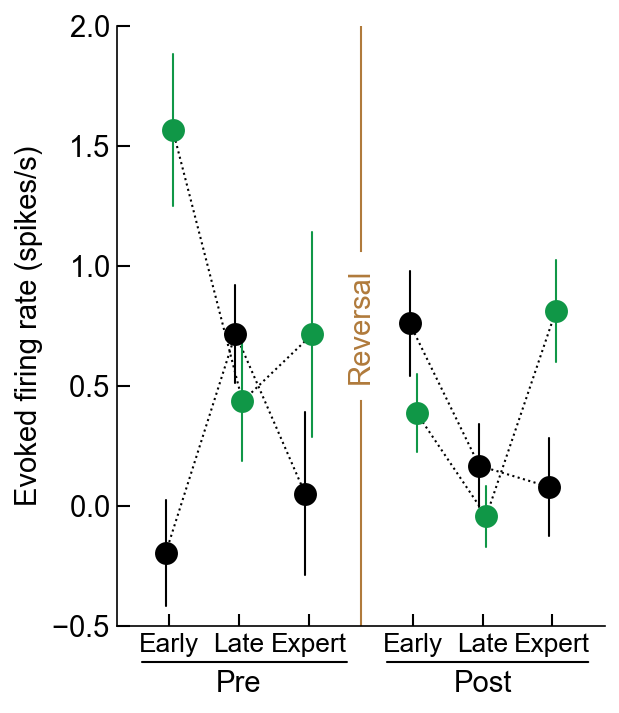

In [8]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([-0.5,2])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\AC\\AC NCR Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [9]:
data_target_AC = SimpleNamespace()
data_target_AC.preearly = Tuning_target_preearly
data_target_AC.prelate = Tuning_target_prelate
data_target_AC.preexpert = Tuning_target_preexpert
data_target_AC.postearly = Tuning_target_postearly
data_target_AC.postlate = Tuning_target_postlate
data_target_AC.postexpert = Tuning_target_postexpert

data_nontarget_AC = SimpleNamespace()
data_nontarget_AC.preearly = Tuning_nontarget_preearly
data_nontarget_AC.prelate = Tuning_nontarget_prelate
data_nontarget_AC.preexpert = Tuning_nontarget_preexpert
data_nontarget_AC.postearly = Tuning_nontarget_postearly
data_nontarget_AC.postlate = Tuning_nontarget_postlate
data_nontarget_AC.postexpert = Tuning_nontarget_postexpert

In [10]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target_AC)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source           SS      DF         MS         F     p-unc  \
0            phase    73.408909     3.0  24.469636  4.582224  0.003395   
1          context     0.011412     1.0   0.011412  0.002137  0.963137   
2  phase * context   143.504723     3.0  47.834908  8.957642  0.000007   
3         Residual  5847.434335  1095.0   5.340123       NaN       NaN   

        np2  
0  0.012398  
1  0.000002  
2  0.023954  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000706  0.002823 -0.382279
8     post-late  baseline  experimental  0.049780  0.066374  0.221668
9    pre-expert  baseline  experimental  0.652658  0.652658 -0.099956
10     pre-late  baseline  experimental  0.004917  0.009834  0.420687
key preearly has 73 non-nan elements
key prelate has 114 non-nan elements
key preexpert has 50 non-nan elements
key postearly has 157 non-nan elements
key postlate has 219 non-nan elements
key postexpert has 

In [11]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget_AC)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source           SS      DF         MS         F     p-unc  \
0            phase    24.876795     3.0   8.292265  1.367223  0.251296   
1          context     7.707920     1.0   7.707920  1.270876  0.259849   
2  phase * context    77.734033     3.0  25.911344  4.272244  0.005214   
3         Residual  6641.222310  1095.0   6.065043       NaN       NaN   

        np2  
0  0.003732  
1  0.001159  
2  0.011569  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.835740  0.835740  0.034367
8     post-late  baseline  experimental  0.038851  0.077702  0.225665
9    pre-expert  baseline  experimental  0.104483  0.139311  0.295135
10     pre-late  baseline  experimental  0.001897  0.007586 -0.438344
key preearly has 73 non-nan elements
key prelate has 114 non-nan elements
key preexpert has 50 non-nan elements
key postearly has 157 non-nan elements
key postlate has 219 non-nan elements
key postexpert has 

# CR

In [12]:
Tuning_target_preearly = []
Tuning_target_prelate = []
Tuning_target_preexpert = []
Tuning_target_postearly = []
Tuning_target_postlate = []
Tuning_target_postexpert = []
Tuning_target_switch = []

Tuning_nontarget_preearly = []
Tuning_nontarget_prelate = []
Tuning_nontarget_preexpert = []
Tuning_nontarget_postearly = []
Tuning_nontarget_postlate = []
Tuning_nontarget_postexpert = []
Tuning_nontarget_switch = []

Tuning_index_preearly = []
Tuning_index_prelate = []
Tuning_index_preexpert = []
Tuning_index_postearly = []
Tuning_index_postlate = []
Tuning_index_postexpert = []
Tuning_index_switch = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        FR_target = sessionfile.responsiveness[clust]['target'].FR
        FR_bl_target = sessionfile.responsiveness[clust]['target'].FRbaseline
        FR_nontarget = sessionfile.responsiveness[clust]['nontarget'].FR
        FR_bl_nontarget = sessionfile.responsiveness[clust]['nontarget'].FRbaseline
        Tuning_target = (FR_target - FR_bl_target)# / FR_bl_target
        Tuning_nontarget = (FR_nontarget - FR_bl_nontarget)# / FR_bl_nontarget
        Tuning_index = (FR_target - FR_nontarget)# / (FR_target+FR_nontarget)
    except Exception as e:
        FRmod = np.nan
        Tuning_target = np.nan
        Tuning_nontarget = np.nan
        Tuning_index = np.nan
        print(e)
    
    if FRmod < 3.5:
        continue
        
    if EILphases[idx] == 'switch':
        Tuning_target_switch.append(Tuning_target)
        Tuning_nontarget_switch.append(Tuning_nontarget)
        Tuning_index_switch.append(Tuning_index)
#         Ramping_switch.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #preearly_animals.append(sessionfile.meta.animal)
    if EILphases[idx] == 'pre early':
        Tuning_target_preearly.append(Tuning_target)
        Tuning_nontarget_preearly.append(Tuning_nontarget)
        Tuning_index_preearly.append(Tuning_index)
#         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        Tuning_target_prelate.append(Tuning_target)
        Tuning_nontarget_prelate.append(Tuning_nontarget)
        Tuning_index_prelate.append(Tuning_index)
#         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        Tuning_target_preexpert.append(Tuning_target)
        Tuning_nontarget_preexpert.append(Tuning_nontarget)
        Tuning_index_preexpert.append(Tuning_index)
#         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        Tuning_target_postearly.append(Tuning_target)
        Tuning_nontarget_postearly.append(Tuning_nontarget)
        Tuning_index_postearly.append(Tuning_index)
#         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        Tuning_target_postlate.append(Tuning_target)
        Tuning_nontarget_postlate.append(Tuning_nontarget)
        Tuning_index_postlate.append(Tuning_index)
#         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        Tuning_target_postexpert.append(Tuning_target)
        Tuning_nontarget_postexpert.append(Tuning_nontarget)
        Tuning_index_postexpert.append(Tuning_index)
#         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postexpert_animals.append(sessionfile.meta.animal)

Tuning_target_preearly = np.array(ilep.rmnan(Tuning_target_preearly))
Tuning_target_prelate = np.array(ilep.rmnan(Tuning_target_prelate))
Tuning_target_preexpert = np.array(ilep.rmnan(Tuning_target_preexpert))
Tuning_target_postearly = np.array(ilep.rmnan(Tuning_target_postearly))
Tuning_target_postlate = np.array(ilep.rmnan(Tuning_target_postlate))
Tuning_target_postexpert = np.array(ilep.rmnan(Tuning_target_postexpert))

Tuning_nontarget_preearly = np.array(ilep.rmnan(Tuning_nontarget_preearly))
Tuning_nontarget_prelate = np.array(ilep.rmnan(Tuning_nontarget_prelate))
Tuning_nontarget_preexpert = np.array(ilep.rmnan(Tuning_nontarget_preexpert))
Tuning_nontarget_postearly = np.array(ilep.rmnan(Tuning_nontarget_postearly))
Tuning_nontarget_postlate = np.array(ilep.rmnan(Tuning_nontarget_postlate))
Tuning_nontarget_postexpert = np.array(ilep.rmnan(Tuning_nontarget_postexpert))

Tuning_index_preearly = np.array(ilep.rmnan(Tuning_index_preearly))
Tuning_index_prelate = np.array(ilep.rmnan(Tuning_index_prelate))
Tuning_index_preexpert = np.array(ilep.rmnan(Tuning_index_preexpert))
Tuning_index_postearly = np.array(ilep.rmnan(Tuning_index_postearly))
Tuning_index_postlate = np.array(ilep.rmnan(Tuning_index_postlate))
Tuning_index_postexpert = np.array(ilep.rmnan(Tuning_index_postexpert))

# Ramping_preearly = np.array(Ramping_preearly)
# Ramping_prelate = np.array(Ramping_prelate)
# Ramping_preexpert = np.array(Ramping_preexpert)
# Ramping_postearly = np.array(Ramping_postearly)
# Ramping_postlate = np.array(Ramping_postlate)
# Ramping_postexpert = np.array(Ramping_postexpert)

1831it [00:35, 51.31it/s] 


In [13]:
CRe_Tuning_target_preearly = Tuning_target_preearly[Tuning_target_preearly>0]
CRe_Tuning_target_prelate = Tuning_target_prelate[Tuning_target_prelate>0]
CRe_Tuning_target_preexpert = Tuning_target_preexpert[Tuning_target_preexpert>0]
CRe_Tuning_target_postearly = Tuning_target_postearly[Tuning_target_postearly>0]
CRe_Tuning_target_postlate = Tuning_target_postlate[Tuning_target_postlate>0]
CRe_Tuning_target_postexpert = Tuning_target_postexpert[Tuning_target_postexpert>0]

CRs_Tuning_target_preearly = Tuning_target_preearly[Tuning_target_preearly<0]
CRs_Tuning_target_prelate = Tuning_target_prelate[Tuning_target_prelate<0]
CRs_Tuning_target_preexpert = Tuning_target_preexpert[Tuning_target_preexpert<0]
CRs_Tuning_target_postearly = Tuning_target_postearly[Tuning_target_postearly<0]
CRs_Tuning_target_postlate = Tuning_target_postlate[Tuning_target_postlate<0]
CRs_Tuning_target_postexpert = Tuning_target_postexpert[Tuning_target_postexpert<0]

In [14]:
CRe_Tuning_nontarget_preearly = Tuning_nontarget_preearly[Tuning_nontarget_preearly>0]
CRe_Tuning_nontarget_prelate = Tuning_nontarget_prelate[Tuning_nontarget_prelate>0]
CRe_Tuning_nontarget_preexpert = Tuning_nontarget_preexpert[Tuning_nontarget_preexpert>0]
CRe_Tuning_nontarget_postearly = Tuning_nontarget_postearly[Tuning_nontarget_postearly>0]
CRe_Tuning_nontarget_postlate = Tuning_nontarget_postlate[Tuning_nontarget_postlate>0]
CRe_Tuning_nontarget_postexpert = Tuning_nontarget_postexpert[Tuning_nontarget_postexpert>0]

CRs_Tuning_nontarget_preearly = Tuning_nontarget_preearly[Tuning_nontarget_preearly<0]
CRs_Tuning_nontarget_prelate = Tuning_nontarget_prelate[Tuning_nontarget_prelate<0]
CRs_Tuning_nontarget_preexpert = Tuning_nontarget_preexpert[Tuning_nontarget_preexpert<0]
CRs_Tuning_nontarget_postearly = Tuning_nontarget_postearly[Tuning_nontarget_postearly<0]
CRs_Tuning_nontarget_postlate = Tuning_nontarget_postlate[Tuning_nontarget_postlate<0]
CRs_Tuning_nontarget_postexpert = Tuning_nontarget_postexpert[Tuning_nontarget_postexpert<0]

In [15]:
print(len(CRe_Tuning_target_preearly) + len(CRs_Tuning_target_preearly))
print(len(CRe_Tuning_target_prelate) + len(CRs_Tuning_target_prelate))
print(len(CRe_Tuning_target_preexpert) + len(CRs_Tuning_target_preexpert))
print(len(CRe_Tuning_target_postearly) + len(CRs_Tuning_target_postearly))
print(len(CRe_Tuning_target_postlate) + len(CRs_Tuning_target_postlate))
print(len(CRe_Tuning_target_postexpert) + len(CRs_Tuning_target_postexpert))

print(len(Tuning_target_preearly))
print(len(Tuning_target_prelate))
print(len(Tuning_target_preexpert))
print(len(Tuning_target_postearly))
print(len(Tuning_target_postlate))
print(len(Tuning_target_postexpert))

75
73
47
149
123
88
75
73
47
149
123
88


In [16]:
print(len(CRe_Tuning_nontarget_preearly) + len(CRs_Tuning_nontarget_preearly))
print(len(CRe_Tuning_nontarget_prelate) + len(CRs_Tuning_nontarget_prelate))
print(len(CRe_Tuning_nontarget_preexpert) + len(CRs_Tuning_nontarget_preexpert))
print(len(CRe_Tuning_nontarget_postearly) + len(CRs_Tuning_nontarget_postearly))
print(len(CRe_Tuning_nontarget_postlate) + len(CRs_Tuning_nontarget_postlate))
print(len(CRe_Tuning_nontarget_postexpert) + len(CRs_Tuning_nontarget_postexpert))

75
73
47
149
123
87


In [17]:
print(len(Tuning_nontarget_preearly))
print(len(Tuning_nontarget_prelate))
print(len(Tuning_nontarget_preexpert))
print(len(Tuning_nontarget_postearly))
print(len(Tuning_nontarget_postlate))
print(len(Tuning_nontarget_postexpert))

75
73
47
149
123
87


## CR evoked

meta NOT subset; don't know how to subset; dropped


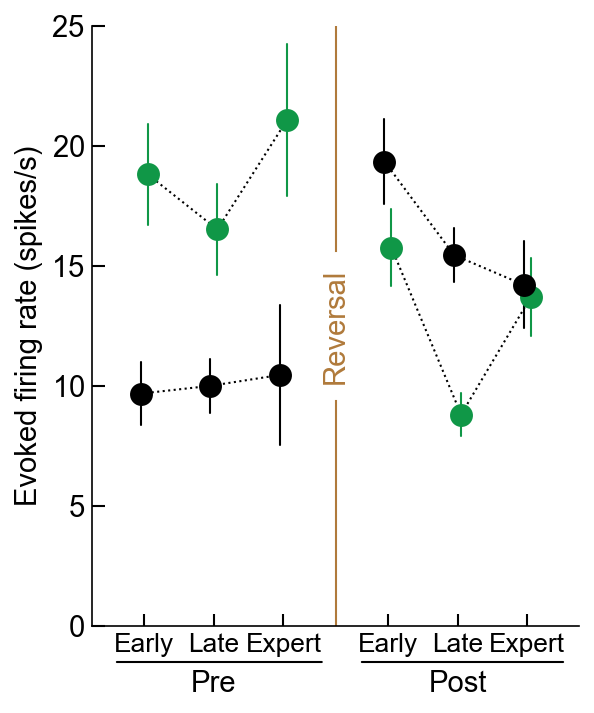

In [18]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [CRe_Tuning_target_preearly,CRe_Tuning_target_prelate,CRe_Tuning_target_preexpert,CRe_Tuning_target_postearly,CRe_Tuning_target_postlate,CRe_Tuning_target_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [CRe_Tuning_nontarget_preearly,CRe_Tuning_nontarget_prelate,CRe_Tuning_nontarget_preexpert,CRe_Tuning_nontarget_postearly,CRe_Tuning_nontarget_postlate,CRe_Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,25])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\AC\\AC CR_e Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

## CR supp

meta NOT subset; don't know how to subset; dropped


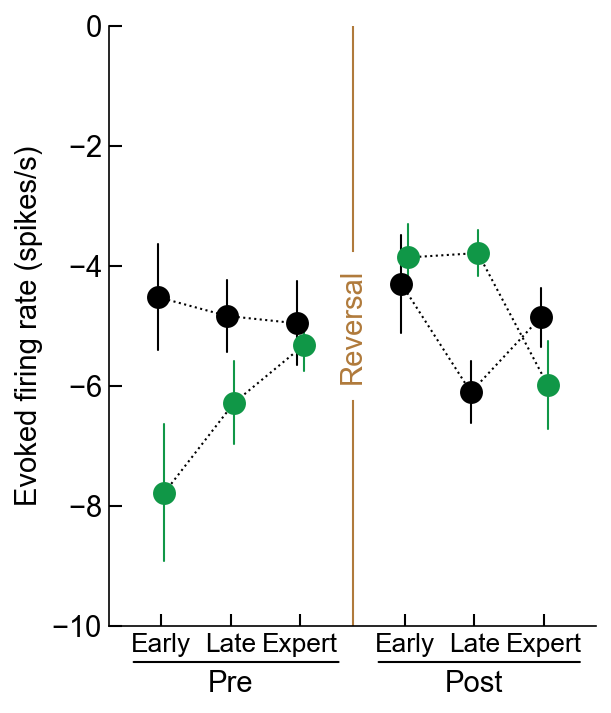

In [19]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [CRs_Tuning_target_preearly,CRs_Tuning_target_prelate,CRs_Tuning_target_preexpert,CRs_Tuning_target_postearly,CRs_Tuning_target_postlate,CRs_Tuning_target_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [CRs_Tuning_nontarget_preearly,CRs_Tuning_nontarget_prelate,CRs_Tuning_nontarget_preexpert,CRs_Tuning_nontarget_postearly,CRs_Tuning_nontarget_postlate,CRs_Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([-10,0])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\AC\\AC CR_s Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [20]:
data_target_AC_e = SimpleNamespace()
data_target_AC_e.preearly = CRe_Tuning_target_preearly
data_target_AC_e.prelate = CRe_Tuning_target_prelate
data_target_AC_e.preexpert = CRe_Tuning_target_preexpert
data_target_AC_e.postearly = CRe_Tuning_target_postearly
data_target_AC_e.postlate = CRe_Tuning_target_postlate
data_target_AC_e.postexpert = CRe_Tuning_target_postexpert

data_nontarget_AC_e = SimpleNamespace()
data_nontarget_AC_e.preearly = CRe_Tuning_nontarget_preearly
data_nontarget_AC_e.prelate = CRe_Tuning_nontarget_prelate
data_nontarget_AC_e.preexpert = CRe_Tuning_nontarget_preexpert
data_nontarget_AC_e.postearly = CRe_Tuning_nontarget_postearly
data_nontarget_AC_e.postlate = CRe_Tuning_nontarget_postlate
data_nontarget_AC_e.postexpert = CRe_Tuning_nontarget_postexpert

In [21]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target_AC_e)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source             SS     DF           MS         F     p-unc  \
0            phase    5337.726091    3.0  1779.242030  8.497265  0.000016   
1          context     179.219818    1.0   179.219818  0.855914  0.355260   
2  phase * context    4054.010443    3.0  1351.336814  6.453685  0.000265   
3         Residual  124377.632830  594.0   209.389954       NaN       NaN   

        np2  
0  0.041150  
1  0.001439  
2  0.031566  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.001604  0.006417 -0.450789
8     post-late  baseline  experimental  0.004182  0.008365  0.454681
9    pre-expert  baseline  experimental  0.349461  0.465948 -0.276798
10     pre-late  baseline  experimental  0.483611  0.483611  0.145293
key preearly has 65 non-nan elements
key prelate has 55 non-nan elements
key preexpert has 37 non-nan elements
key postearly has 135 non-nan elements
key postlate has 94 non-nan elements
key po

In [22]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget_AC_e)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source             SS     DF           MS          F  \
0            phase    6448.357981    3.0  2149.452660  10.592446   
1          context     461.859787    1.0   461.859787   2.276033   
2  phase * context     501.751131    3.0   167.250377   0.824205   
3         Residual  123174.365967  607.0   202.923173        NaN   

          p-unc       np2  
0  8.505157e-07  0.049747  
1  1.319079e-01  0.003736  
2  4.808057e-01  0.004057  
3           NaN       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.112179  0.405396  0.092539
8     post-late  baseline  experimental  0.271111  0.405396  0.225562
9    pre-expert  baseline  experimental  0.304047  0.405396 -0.036941
10     pre-late  baseline  experimental  0.522215  0.522215 -0.035566
key preearly has 55 non-nan elements
key prelate has 56 non-nan elements
key preexpert has 33 non-nan elements
key postearly has 136 non-nan elements
key postlate has 1

In [23]:
data_target_AC_s = SimpleNamespace()
data_target_AC_s.preearly = CRs_Tuning_target_preearly
data_target_AC_s.prelate = CRs_Tuning_target_prelate
data_target_AC_s.preexpert = CRs_Tuning_target_preexpert
data_target_AC_s.postearly = CRs_Tuning_target_postearly
data_target_AC_s.postlate = CRs_Tuning_target_postlate
data_target_AC_s.postexpert = CRs_Tuning_target_postexpert

data_nontarget_AC_s = SimpleNamespace()
data_nontarget_AC_s.preearly = CRs_Tuning_nontarget_preearly
data_nontarget_AC_s.prelate = CRs_Tuning_nontarget_prelate
data_nontarget_AC_s.preexpert = CRs_Tuning_nontarget_preexpert
data_nontarget_AC_s.postearly = CRs_Tuning_nontarget_postearly
data_nontarget_AC_s.postlate = CRs_Tuning_nontarget_postlate
data_nontarget_AC_s.postexpert = CRs_Tuning_nontarget_postexpert

In [24]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target_AC_s)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source          SS     DF         MS         F     p-unc       np2
0            phase  183.438227    3.0  61.146076  9.177649  0.000014  0.163368
1          context    3.044356    1.0   3.044356  0.456939  0.500165  0.003230
2  phase * context   75.984990    3.0  25.328330  3.801626  0.011696  0.074833
3         Residual  939.412288  141.0   6.662498       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.010026  0.040102  0.811511
8     post-late  baseline  experimental  0.886646  0.886646 -0.035285
9    pre-expert  baseline  experimental  0.773563  0.886646 -0.370822
10     pre-late  baseline  experimental  0.240056  0.480113 -0.455488
key preearly has 10 non-nan elements
key prelate has 18 non-nan elements
key preexpert has 10 non-nan elements
key postearly has 14 non-nan elements
key postlate has 29 non-nan elements
key postexpert has 21 non-nan elements


In [25]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget_AC_s)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source          SS     DF         MS         F     p-unc       np2
0            phase   19.100471    3.0   6.366824  0.866014  0.460672  0.020047
1          context    1.865466    1.0   1.865466  0.253740  0.615326  0.001994
2  phase * context   37.718560    3.0  12.572853  1.710157  0.168228  0.038829
3         Residual  933.687834  127.0   7.351873       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.096482  0.192964 -0.574288
8     post-late  baseline  experimental  0.093661  0.192964  0.689096
9    pre-expert  baseline  experimental  1.000000  1.000000  0.046756
10     pre-late  baseline  experimental  0.293063  0.390751  0.091660
key preearly has 20 non-nan elements
key prelate has 17 non-nan elements
key preexpert has 14 non-nan elements
key postearly has 13 non-nan elements
key postlate has 20 non-nan elements
key postexpert has 14 non-nan elements


# old

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\Manuscript\../..\InsanallyLabEphysTools\plotting_helpers.py:167: RuntimeWarning: invalid value encountered in log10
  ymin = np.log10(ymin)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


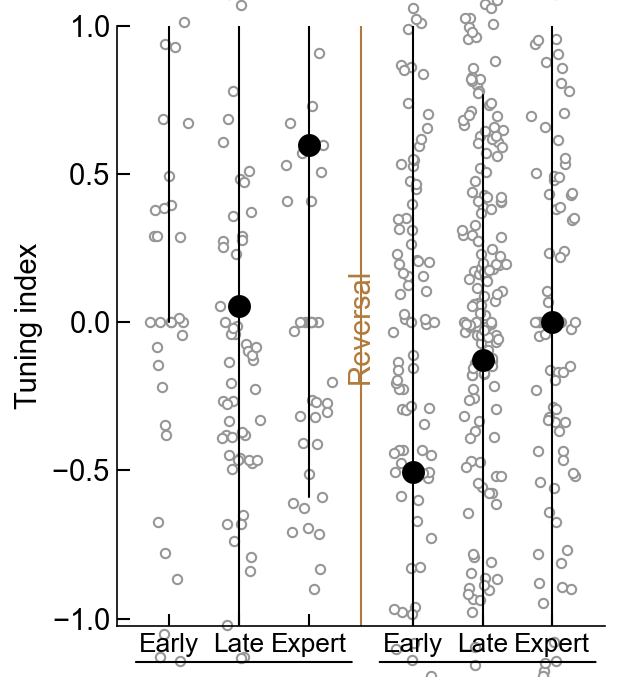

In [12]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [Tuning_index_preearly,Tuning_index_prelate,Tuning_index_preexpert,Tuning_index_postearly,Tuning_index_postlate,Tuning_index_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
# X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=1,zorder=-10,clip_on=False)
# ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= 'k'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
# ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-1.025,1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ylab = ax.set_ylabel('Tuning index')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Tuning index over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [13]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(Tuning_index_preearly)
data_dec.prelate = np.abs(Tuning_index_prelate)
data_dec.preexpert = np.abs(Tuning_index_preexpert)
data_dec.postearly = np.abs(Tuning_index_postearly)
data_dec.postlate = np.abs(Tuning_index_postlate)
data_dec.postexpert = np.abs(Tuning_index_postexpert)
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source             SS      DF          MS         F     p-unc  \
0            phase     526.879277     3.0  175.626426  2.543052  0.054664   
1          context     252.000834     1.0  252.000834  3.648945  0.056260   
2  phase * context    2013.547738     3.0  671.182579  9.718652  0.000002   
3         Residual  127418.066137  1845.0   69.061282       NaN       NaN   

        np2  
0  0.004118  
1  0.001974  
2  0.015557  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.086248  0.114997 -0.129872
8     post-late  baseline  experimental  0.000002  0.000009  0.290611
9    pre-expert  baseline  experimental  0.909629  0.909629 -0.273382
10     pre-late  baseline  experimental  0.003506  0.007013  0.340525
key preearly has 148 non-nan elements
key prelate has 187 non-nan elements
key preexpert has 97 non-nan elements
key postearly has 306 non-nan elements
key postlate has 342 non-nan elements
key

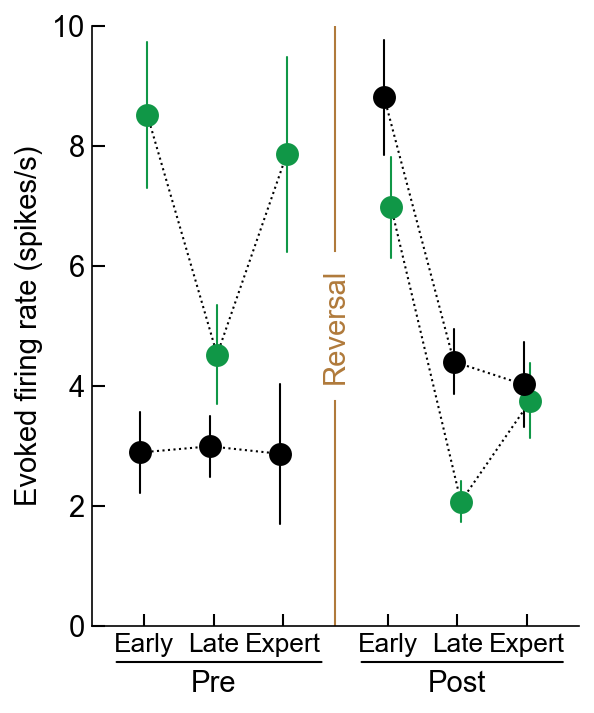

In [14]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Target-nontarget tuning over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [15]:
# data_target = SimpleNamespace()
# data_target.preearly = np.abs(Tuning_target_preearly)
# data_target.prelate = np.abs(Tuning_target_prelate)
# data_target.preexpert = np.abs(Tuning_target_preexpert)
# data_target.postearly = np.abs(Tuning_target_postearly)
# data_target.postlate = np.abs(Tuning_target_postlate)
# data_target.postexpert = np.abs(Tuning_target_postexpert)

# data_nontarget = SimpleNamespace()
# data_nontarget.preearly = np.abs(Tuning_nontarget_preearly)
# data_nontarget.prelate = np.abs(Tuning_nontarget_prelate)
# data_nontarget.preexpert = np.abs(Tuning_nontarget_preexpert)
# data_nontarget.postearly = np.abs(Tuning_nontarget_postearly)
# data_nontarget.postlate = np.abs(Tuning_nontarget_postlate)
# data_nontarget.postexpert = np.abs(Tuning_nontarget_postexpert)

data_target = SimpleNamespace()
data_target.preearly = Tuning_target_preearly
data_target.prelate = Tuning_target_prelate
data_target.preexpert = Tuning_target_preexpert
data_target.postearly = Tuning_target_postearly
data_target.postlate = Tuning_target_postlate
data_target.postexpert = Tuning_target_postexpert

data_nontarget = SimpleNamespace()
data_nontarget.preearly = Tuning_nontarget_preearly
data_nontarget.prelate = Tuning_nontarget_prelate
data_nontarget.preexpert = Tuning_nontarget_preexpert
data_nontarget.postearly = Tuning_nontarget_postearly
data_nontarget.postlate = Tuning_nontarget_postlate
data_nontarget.postexpert = Tuning_nontarget_postexpert

ilep.nonparametricIndependentStatsCompareToOther(data_target,data_nontarget)

            Source             SS      DF           MS          F  \
0            phase    8589.939745     5.0  1717.987949  12.477445   
1          context      11.902397     1.0    11.902397   0.086445   
2  phase * context    5203.094346     5.0  1040.618869   7.557832   
3         Residual  363081.883596  2637.0   137.687480        NaN   

          p-unc       np2  
0  5.421236e-12  0.023112  
1  7.687693e-01  0.000033  
2  4.662527e-07  0.014128  
3           NaN       NaN  

          phase  A  B     p-unc    p-corr    hedges
16   post-early  A  B  0.039305  0.058957 -0.116183
17  post-expert  A  B  0.480800  0.576960 -0.025996
18    post-late  A  B  0.037192  0.058957 -0.278207
19    pre-early  A  B  0.000002  0.000010  0.468557
20   pre-expert  A  B  0.020782  0.058957  0.357420
21     pre-late  A  B  0.876845  0.876845  0.163254
key preearly has 148 and 148 non-nan elements
key prelate has 187 and 187 non-nan elements
key preexpert has 97 and 97 non-nan elements
key postearly

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-early,post-expert,False,False,175962.5,two-sided,5.110268e-07,3.832701e-06,fdr_bh,0.293626
1,phase,-,post-early,post-late,False,False,255743.0,two-sided,5.059067e-12,7.588600e-11,fdr_bh,0.373939
2,phase,-,post-early,pre-early,False,False,96370.0,two-sided,1.178248e-01,1.963747e-01,fdr_bh,0.148912
3,phase,-,post-early,pre-expert,False,False,67977.5,two-sided,2.302791e-03,6.908374e-03,fdr_bh,0.164414
4,phase,-,post-early,pre-late,False,False,133107.0,two-sided,1.698701e-05,8.493505e-05,fdr_bh,0.302088
5,phase,-,post-expert,post-late,False,False,174869.0,two-sided,1.822328e-01,2.484992e-01,fdr_bh,0.069884
6,phase,-,post-expert,pre-early,False,False,64374.0,two-sided,9.394128e-03,2.348532e-02,fdr_bh,-0.162703
7,phase,-,post-expert,pre-expert,False,False,46399.5,two-sided,6.568763e-01,7.579342e-01,fdr_bh,-0.127545
8,phase,-,post-expert,pre-late,False,False,90257.5,two-sided,7.440013e-01,7.971442e-01,fdr_bh,0.013204
9,phase,-,post-late,pre-early,False,False,85723.5,two-sided,1.379197e-04,5.171987e-04,fdr_bh,-0.252185


In [16]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target)

            Source             SS      DF           MS          F  \
0            phase    3380.311657     3.0  1126.770552   9.445895   
1          context     992.283583     1.0   992.283583   8.318470   
2  phase * context    5326.325394     3.0  1775.441798  14.883808   
3         Residual  220203.425319  1846.0   119.286796        NaN   

          p-unc       np2  
0  3.410865e-06  0.015119  
1  3.969890e-03  0.004486  
2  1.414901e-09  0.023617  
3           NaN       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.263090e-02  1.684120e-02 -0.211322
8     post-late  baseline  experimental  1.256571e-07  5.026283e-07  0.441669
9    pre-expert  baseline  experimental  1.653783e-01  1.653783e-01 -0.255090
10     pre-late  baseline  experimental  2.640948e-04  5.281897e-04  0.307938
key preearly has 148 non-nan elements
key prelate has 187 non-nan elements
key preexpert has 97 non-nan elements
key postea

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,178421.5,two-sided,6.013990e-02,9.020984e-02,fdr_bh,-0.163086
1,phase,-,post-expert,pre-expert,False,False,75388.0,two-sided,2.210342e-02,4.420683e-02,fdr_bh,-0.289755
2,phase,-,post-expert,pre-late,False,False,80702.5,two-sided,5.885648e-06,3.531389e-05,fdr_bh,-0.346298
3,phase,-,post-late,pre-expert,False,False,88685.0,two-sided,3.786069e-01,3.786069e-01,fdr_bh,-0.106611
4,phase,-,post-late,pre-late,False,False,95399.0,two-sided,1.842268e-03,5.526803e-03,fdr_bh,-0.158262
5,phase,-,pre-expert,pre-late,False,False,44517.0,two-sided,1.685750e-01,2.022899e-01,fdr_bh,-0.047512
6,context,-,baseline,experimental,False,False,457205.0,two-sided,1.140156e-02,NaN,NaN,0.118623
7,phase * context,post-expert,baseline,experimental,False,False,36841.0,two-sided,1.263090e-02,1.684120e-02,fdr_bh,-0.211322
8,phase * context,post-late,baseline,experimental,False,False,64900.0,two-sided,1.256571e-07,5.026283e-07,fdr_bh,0.441669
9,phase * context,pre-expert,baseline,experimental,False,False,8158.5,two-sided,1.653783e-01,1.653783e-01,fdr_bh,-0.255090


In [17]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget)

            Source             SS      DF           MS          F  \
0            phase    4380.504562     3.0  1460.168187  12.075992   
1          context    1299.259985     1.0  1299.259985  10.745237   
2  phase * context    1856.467309     3.0   618.822436   5.117832   
3         Residual  223088.112535  1845.0   120.914966        NaN   

          p-unc       np2  
0  7.913433e-08  0.019258  
1  1.064909e-03  0.005790  
2  1.581809e-03  0.008253  
3           NaN       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.639270  0.639270  0.036405
8     post-late  baseline  experimental  0.000008  0.000031  0.323667
9    pre-expert  baseline  experimental  0.265722  0.354296  0.014287
10     pre-late  baseline  experimental  0.251947  0.354296 -0.013632
key preearly has 148 non-nan elements
key prelate has 187 non-nan elements
key preexpert has 97 non-nan elements
key postearly has 306 non-nan elements
key postlat

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,169520.0,two-sided,0.001137,0.003239,fdr_bh,-0.182067
1,phase,-,post-expert,pre-expert,False,False,84304.5,two-sided,0.753375,0.951517,fdr_bh,0.130767
2,phase,-,post-expert,pre-late,False,False,99175.0,two-sided,0.792930,0.951517,fdr_bh,0.137017
3,phase,-,post-late,pre-expert,False,False,103941.0,two-sided,0.001619,0.003239,fdr_bh,0.283715
4,phase,-,post-late,pre-late,False,False,122170.0,two-sided,0.001236,0.003239,fdr_bh,0.294377
5,phase,-,pre-expert,pre-late,False,False,47670.0,two-sided,0.964204,0.964204,fdr_bh,0.000328
6,context,-,baseline,experimental,False,False,458754.0,two-sided,0.006732,NaN,NaN,0.130751
7,phase * context,post-expert,baseline,experimental,False,False,42671.5,two-sided,0.639270,0.639270,fdr_bh,0.036405
8,phase * context,post-late,baseline,experimental,False,False,62973.0,two-sided,0.000008,0.000031,fdr_bh,0.323667
9,phase * context,pre-expert,baseline,experimental,False,False,9800.5,two-sided,0.265722,0.354296,fdr_bh,0.014287


In [26]:
print(np.median(Tuning_target_preearly))
print(np.median(Tuning_target_prelate))
print(np.median(Tuning_target_preexpert))
print(np.median(Tuning_target_postearly))
print(np.median(Tuning_target_postlate))
print(np.median(Tuning_target_postexpert))

4.2629218786877505
1.7910447761194028
3.575757575757575
1.6781609195402298
0.9898107714701601
1.7794708994708976


In [75]:
[len(n) for n in [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]]

[148, 187, 97, 349, 299, 268]

In [76]:
[len(n) for n in [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]]

[148, 187, 97, 349, 299, 268]

In [77]:
np.sum([len(n) for n in [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]])

1348